In [1]:
#Place for all the Functions

#This is grabbing data
def get_data(url, drop=[]): 
  import pandas as pd
  df = pd.read_csv(url)
  if len(drop) > 0:
    for col in drop:
      df.drop(columns=[col], inplace=True)
  return df

#Anything that did not appear more than 5% of the time it gets put into this group
def bin_groups(df, percent=.05):
  import pandas as pd
  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      for group, count in df[col].value_counts().iteritems():
        if count / len(df) < percent:
          df.loc[df[col] == group, col] = 'Other'
  return df

#Drop columns that have more than 50% missing
def drop_columns_missing_50(df, cutoff=.5):
  import pandas as pd
  for col in df:
    if df[col].isna().sum() / len(df) > cutoff:
      df.drop(columns=[col], inplace=True)
  return df

#This does something haha
def impute_mean(df):
  from sklearn.impute import SimpleImputer
  import pandas as pd, numpy as np
  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      df = pd.get_dummies(df, columns=[col], drop_first=True)
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
  return df

#If there is not enough variance, then we will toss it out
#This is determined by the "p" parameter 
#This does not take into account Multi Collinearity
#But we might want to run this function becuase it is fast
def fs_variance(df, label="", p=0.8):
  from sklearn.feature_selection import VarianceThreshold
  import pandas as pd

  if label != "":
    X = df.drop(columns=[label])
    
  sel = VarianceThreshold(threshold=(p * (1 - p)))
  sel.fit_transform(X)

  # Add the label back in after removing poor features
  return df[sel.get_feature_names_out()].join(df[label])

#The "k" represents how many splits we want
#We are splitting out data frame into our features and our label
#Setting up our cross validation object
#say "k" is 5, that means we are splitting our data into 5 train/test sets
#This then means we will get 5 different values for R2
#We will then take the average of these R2 and that will be our Avg R2
#This is the R2 we will use to check against
def fit_crossvalidate_mlr(df, k, label, repeat=True):
  from sklearn.linear_model import LinearRegression
  from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
  import pandas as pd
  from numpy import mean, std
  X = df.drop(label,axis=1)
  y = df[label]
  if repeat:
    cv = RepeatedKFold(n_splits=k, n_repeats=5, random_state=12345)
  else:
    cv = KFold(n_splits=k, random_state=12345, shuffle=True)
  scores = cross_val_score(LinearRegression(), X, y, scoring='r2', cv=cv, n_jobs=-1)
  print(f'Average R-squared:\t{mean(scores)}')
  return LinearRegression().fit(X, y)

def dump_pickle(model, file_name):
  import pickle
  pickle.dump(model, open(file_name, "wb"))

def load_pickle(file_name):
  import pickle
  model = pickle.load(open(file_name, "rb"))
  return model

In [17]:
# Train and test set
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

df = get_data('CuperCut_TrainCrash.csv', ["CRASH_ID"])
df = bin_groups(df, 0.05)
df = drop_columns_missing_50(df)
df = impute_mean(df)

#df = fs_variance(df, label="CRASH_SEVERITY_ID", p=.5)

model = fit_crossvalidate_mlr(df, 5, label='CRASH_SEVERITY_ID')

df

Average R-squared:	0.18966380192691812


,MILEPOINT,CRASH_SEVERITY_ID,PEDESTRIAN_INVOLVED,BICYCLIST_INVOLVED,MOTORCYCLE_INVOLVED,IMPROPER_RESTRAINT,UNRESTRAINED,DUI,INTERSECTION_RELATED,WILD_ANIMAL_RELATED,...,ROUTE_Other,MAIN_ROAD_NAME_Other,CITY_Other,CITY_SALT LAKE CITY,CITY_WEST VALLEY CITY,COUNTY_NAME_Other,COUNTY_NAME_SALT LAKE,COUNTY_NAME_UTAH,COUNTY_NAME_WEBER,WORK_ZONE_RELATED_Other
0,4.5600,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.7020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.3510,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.4380,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.7960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19509,4.8455,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19510,0.3740,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19511,0.6560,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
19512,141.2000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
df

,MILEPOINT,CRASH_SEVERITY_ID,PEDESTRIAN_INVOLVED,BICYCLIST_INVOLVED,MOTORCYCLE_INVOLVED,IMPROPER_RESTRAINT,UNRESTRAINED,DUI,INTERSECTION_RELATED,WILD_ANIMAL_RELATED,...,ROUTE_Other,MAIN_ROAD_NAME_Other,CITY_Other,CITY_SALT LAKE CITY,CITY_WEST VALLEY CITY,COUNTY_NAME_Other,COUNTY_NAME_SALT LAKE,COUNTY_NAME_UTAH,COUNTY_NAME_WEBER,WORK_ZONE_RELATED_Other
0,4.5600,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.7020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.3510,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.4380,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.7960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19509,4.8455,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19510,0.3740,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19511,0.6560,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
19512,141.2000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Average R-squared:	0.18930810923360947


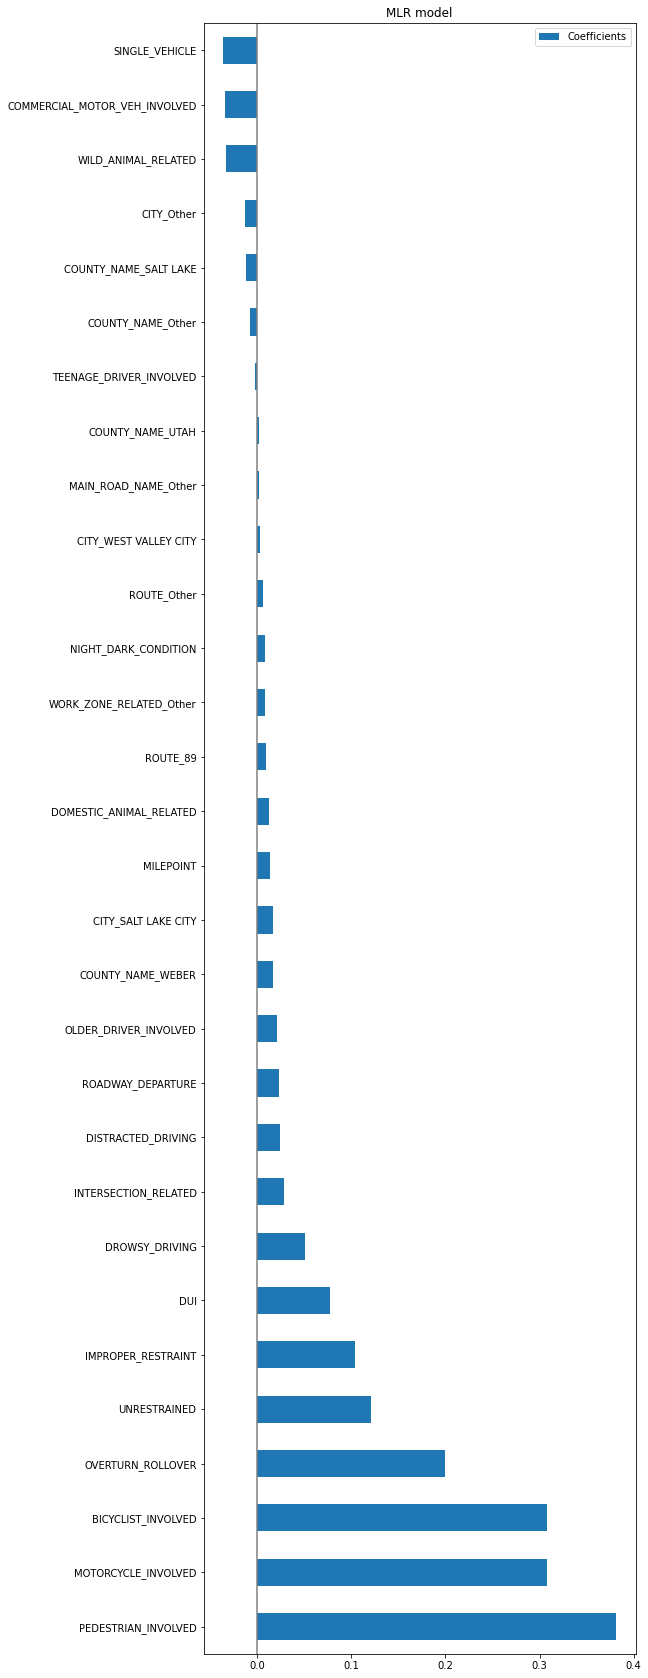

In [3]:
# Need to standardize our features so they are all on the same scale
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

# Standardize the data to compare feature importances (standardize data (so we can compare))
df_minmax = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df), columns=df.columns)

# Run our fit_crossvalidate_mlr function to get back a trained model
model = fit_crossvalidate_mlr(df_minmax, 10, label='CRASH_SEVERITY_ID')

coefs = pd.DataFrame(
  model.coef_,
  columns=['Coefficients'], index=df_minmax.drop(columns=['CRASH_SEVERITY_ID']).columns
)

coefs.sort_values(by=['Coefficients'], ascending=False, inplace=True)

coefs.plot(kind='barh', figsize=(10, 30))
plt.title('MLR model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [4]:
# VIF TIME

def vif(df, label=""):
  import pandas as pd
  from sklearn.linear_model import LinearRegression
  
  # initialize dictionaries
  vif_dict, tolerance_dict = {}, {}

  # drop unnecessary columns if they are found in the dataframe
  if label in df.columns: df.drop(columns=[label], inplace=True)
  if 'const' in df.columns: df.drop(columns=['const'], inplace=True)

  # form input data for each exogenous variable
  for col in df:
    y = df[col]
    X = df.drop(columns=[col])
    
    # extract r-squared from the fit
    r_squared = LinearRegression().fit(X, y).score(X, y)

    # calculate VIF
    if r_squared < 1: # Prevent division by zero runtime error
      vif = 1/(1 - r_squared) 
    else:
      vif = 100
    vif_dict[col] = vif

    # calculate tolerance
    tolerance = 1 - r_squared
    tolerance_dict[col] = tolerance

  # generate the DataFrame to return
  return pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict}).sort_values(by=['VIF'], ascending=False)

vif(df).head(20)

,VIF,Tolerance
ROUTE_Other,6.407352,0.156071
SINGLE_VEHICLE,4.271322,0.234120
MAIN_ROAD_NAME_Other,4.220854,0.236919
MILEPOINT,3.998592,0.250088
COUNTY_NAME_SALT LAKE,3.490743,0.286472
ROADWAY_DEPARTURE,3.193965,0.313091
COUNTY_NAME_Other,3.142115,0.318257
ROUTE_89,3.028699,0.330175
CITY_Other,2.535910,0.394336
COUNTY_NAME_UTAH,2.232440,0.447940


In [5]:
# Because of the multicollinearity issues we're seeing with our data, let's fit a decision tree instead of MLR

# Multivariate feature importance for tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from numpy import mean

y = df.CRASH_SEVERITY_ID
X = df.drop(columns=['CRASH_SEVERITY_ID'])

model = DecisionTreeRegressor()
model.fit(X, y)

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=12345)
scores = cross_val_score(DecisionTreeRegressor(), X, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'Decision Tree R-squared:\t{mean(scores)}')

Decision Tree R-squared:	-0.5425890843659686


In [6]:
# Previously, we determined feature importance by visualizing the decision tree
# While this would work, it isn't very practical
# researchers have developed a concept called permutation feature importance (PFI)
# which is the decrease in model score (e.g., R2) when a single feature is removed from the model

df_fi = pd.DataFrame({"Feature Importance":model.feature_importances_}, index=df.drop(columns=['CRASH_SEVERITY_ID']).columns)
df_fi.sort_values(by=['Feature Importance'], ascending=False).head()

,Feature Importance
MILEPOINT,0.511151
MOTORCYCLE_INVOLVED,0.055615
OVERTURN_ROLLOVER,0.040721
PEDESTRIAN_INVOLVED,0.039664
NIGHT_DARK_CONDITION,0.034215


In [7]:
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
  
# Import data and follow prior cleaning steps
# (Normal Pipeline)
dfv = get_data('CuperCut_TrainCrash.csv', ['CRASH_ID'])
dfv = bin_groups(dfv)
dfv = drop_columns_missing_50(dfv)
dfv = impute_mean(dfv)
  
# Select features only
X = dfv.drop(columns=['CRASH_SEVERITY_ID'])
  
# View the total number of features before reducing
print(X.shape)
  
# Calculate variance based on desired p-value so that Variance = p(1 - p)
# The code below uses p = 0.8 as the cutoff value:
p = 0.8
sel = VarianceThreshold(threshold=(p * (1 - p)))
sel.fit_transform(X)
X_reduced = pd.DataFrame(sel.fit_transform(X))
  
# View the remaining number of features
print(X_reduced.shape)

(19514, 30)
(19514, 9)


In [8]:
sel.get_feature_names_out()


array(['MILEPOINT', 'INTERSECTION_RELATED', 'TEENAGE_DRIVER_INVOLVED',
       'NIGHT_DARK_CONDITION', 'SINGLE_VEHICLE', 'ROUTE_Other',
       'CITY_Other', 'COUNTY_NAME_Other', 'COUNTY_NAME_SALT LAKE'],
      dtype=object)

In [9]:
# Call the Function for the Variance threshold in our pipeline

vardf = get_data('CuperCut_TrainCrash.csv', ['CRASH_ID'])
vardf = bin_groups(vardf)
vardf = drop_columns_missing_50(vardf)
vardf = impute_mean(vardf)
vardf = fs_variance(vardf, label="CRASH_SEVERITY_ID")
model = fit_crossvalidate_mlr(vardf, 10, "CRASH_SEVERITY_ID")


#MLR With all Features R2 = 0.18966380192691812
#MLR with Variance Threshold used R2 = 0.014341587255520503


Average R-squared:	0.014341587255520503


In [10]:
#Slect K best feature Selection
# the "k" represents the number of columns we want to keep
def fs_kbest(df, k=10, label=""):
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import r_regression
  import pandas as pd
  
  X = df.drop(columns=[label])
  y = df[label]

  # Select the top k features based on a given bivariate metric
  # Looking at each feature and its correlation to the label
  # But still not getting rid of the multi colliniarity issue
  sel = SelectKBest(r_regression, k=k)
  sel.fit_transform(X, y)
  
  return df[sel.get_feature_names_out()].join(df[label])

# Integrate this new function into the pipeline:
kdf = get_data('CuperCut_TrainCrash.csv', ['CRASH_ID'])
kdf = bin_groups(kdf)
kdf = drop_columns_missing_50(kdf)
kdf = impute_mean(kdf)
kdf = fs_kbest(kdf, 20, label="CRASH_SEVERITY_ID") # Keep top 20 to validly compare to VarianceThreshold example
model = fit_crossvalidate_mlr(kdf, 10, "CRASH_SEVERITY_ID")

#MLR With all Features R2 = 0.18966380192691812
#MLR with Variance Threshold used R2 = 0.014341587255520503
#MLR with Select K Best with top 9 R2 = 0.17866264279980612
#MLR with Select K Best with top 20 R2 = 0.18685250796314865

Average R-squared:	0.18685250796314865


In [11]:
#L1 Based Feature Selection:
# The first method is based on linear modeling, known as L1-based feature selection (DOES account for Multi Colliniarity BUT is slower)
# This take a while so let's Wordle while this runs

def fs_select_linear(df, label=""):
  from sklearn.svm import LinearSVC
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X = df.drop(label,axis=1)
  y = df[label]

  # As C increases, more features are kept
  lsvc = LinearSVC(C=0.05, penalty="l1", dual=False).fit(X, y)
  sel = SelectFromModel(lsvc, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]

# Integrate this new function into the pipeline:
ldf = get_data('CuperCut_TrainCrash.csv', ['CRASH_ID'])
ldf = bin_groups(ldf)
ldf = drop_columns_missing_50(ldf)
ldf = impute_mean(ldf)
ldf = fs_select_linear(ldf, label="CRASH_SEVERITY_ID")
model = fit_crossvalidate_mlr(ldf, 10, "CRASH_SEVERITY_ID")

#MLR With all Features R2 = 0.18966380192691812
#MLR with Variance Threshold used R2 = 0.014341587255520503
#MLR with Select K Best with top 9 R2 = 0.17866264279980612
#MLR with Select K Best with top 20 R2 = 0.18685250796314865
#MLR with fs select liner R2 (30 features)= 0.1893704622435573


C:\Users\kayle\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Average R-squared:	0.1893704622435573


In [12]:
ldf.shape

ldf.columns
#30 features were kept  

Index(['MILEPOINT', 'PEDESTRIAN_INVOLVED', 'BICYCLIST_INVOLVED',
       'MOTORCYCLE_INVOLVED', 'IMPROPER_RESTRAINT', 'UNRESTRAINED', 'DUI',
       'INTERSECTION_RELATED', 'WILD_ANIMAL_RELATED', 'OVERTURN_ROLLOVER',
       'COMMERCIAL_MOTOR_VEH_INVOLVED', 'TEENAGE_DRIVER_INVOLVED',
       'OLDER_DRIVER_INVOLVED', 'NIGHT_DARK_CONDITION', 'SINGLE_VEHICLE',
       'DISTRACTED_DRIVING', 'DROWSY_DRIVING', 'ROADWAY_DEPARTURE', 'ROUTE_89',
       'ROUTE_Other', 'MAIN_ROAD_NAME_Other', 'CITY_Other',
       'CITY_SALT LAKE CITY', 'CITY_WEST VALLEY CITY', 'COUNTY_NAME_Other',
       'COUNTY_NAME_SALT LAKE', 'COUNTY_NAME_UTAH', 'COUNTY_NAME_WEBER',
       'WORK_ZONE_RELATED_Other', 'CRASH_SEVERITY_ID'],
      dtype='object')

In [13]:
#Tree Based Recursive Selectionn:
# Let's perform a similar technique using tree-based modeling

def fs_select_trees(df, label=""):
  from sklearn.ensemble import ExtraTreesClassifier
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X = df.drop(columns=[label])
  y = df[label]

  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X, y)
  sel = SelectFromModel(clf, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]

# Integrate this new function into the pipeline:
tdf = get_data('CuperCut_TrainCrash.csv', ['CRASH_ID'])
tdf = bin_groups(tdf)
tdf = drop_columns_missing_50(tdf)
tdf = impute_mean(tdf)
tdf = fs_select_trees(tdf, label="CRASH_SEVERITY_ID")
model = fit_crossvalidate_mlr(tdf, 10, "CRASH_SEVERITY_ID")

#MLR With all Features R2 = 0.18966380192691812 --> original
#MLR with Variance Threshold used R2 = 0.014341587255520503
#MLR with Select K Best with top 9 R2 = 0.17866264279980612
#MLR with Select K Best with top 20 R2 = 0.18685250796314865
#MLR with fs select liner R2 (30 features)= 0.1893704622435573 --> Best one we are going with to select features
#MLR with Tree Recursive Selection = -0.0004624694798549167

Average R-squared:	-0.0004624694798549167


C:\Users\kayle\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [14]:
tdf.shape

(19514, 2)